In [118]:
import os
import cv2
import numba as nb
import numpy as np
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

In [3]:
results_dir = "../results/CD/"
dataset_dir = "../datasets/FDP"

In [21]:
for seed in os.listdir(results_dir):
    for phase in os.listdir(os.path.join(results_dir, seed)):
        for image_name in os.listdir(os.path.join(results_dir, seed, phase, "images")):
            if "synthesized" in image_name:
                im = cv2.cvtColor(
                    cv2.imread(os.path.join(results_dir, seed, phase, "images", image_name)),
                    cv2.COLOR_BGR2GRAY
                )
                im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX)
                cv2.imwrite(os.path.join(results_dir, seed, phase, "images", image_name[:-4] + ".png"), im)

In [ ]:
for seed in os.listdir(results_dir):
    for phase in os.listdir(os.path.join(results_dir, seed)):
        for image_name in os.listdir(os.path.join(results_dir, seed, phase, "images")):
            if ".jpg" in image_name:
                os.remove(os.path.join(results_dir, seed, phase, "images", image_name))

In [6]:
@nb.njit
def MSE(im1, im2):
    s = 0.0
    for x in range(128):
        for y in range(128):
            difference = (im1[y, x, 0] - im2[y, x, 0]) / 255
            s = s + difference*difference
    return s / (128**2)

In [7]:
for seed in os.listdir(results_dir):
    with open(f'{seed}.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["code", "loss", "phase"])
        for phase in os.listdir(os.path.join(results_dir, seed)):
            phase_col = "test" if phase == "val_latest" else phase.split("_")[0]
            for image_name in os.listdir(os.path.join(results_dir, seed, phase, "images")):
                code = image_name.split("_")[0]
                    
                im1 = cv2.imread(os.path.join(dataset_dir, code, code + "_+0+0+0.png"))
                im2 = cv2.imread(os.path.join(results_dir, seed, phase, "images", image_name))
                im2 = cv2.normalize(im2, None, 0, 255, norm_type=cv2.NORM_MINMAX)
                
                writer.writerow([code, MSE(im1.astype(np.int16), im2.astype(np.int16)), phase_col])

In [122]:
df_groups = pd.read_csv("space_groups.csv", index_col=0)
dfs = [pd.read_csv(f"seed{s}_CD.csv", index_col=0) for s in range(5)]
with open('losses_averaged.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["code", "group", "loss"])
    for code in os.listdir(dataset_dir):
        writer.writerow([
            code,
            df_groups.loc[int(code)]["space_group"],
            np.mean([
                dfs[0].loc[int(code)]["loss"],
                dfs[1].loc[int(code)]["loss"],
                dfs[2].loc[int(code)]["loss"],
                dfs[3].loc[int(code)]["loss"],
                dfs[4].loc[int(code)]["loss"],
            ])
        ])

<Axes: >

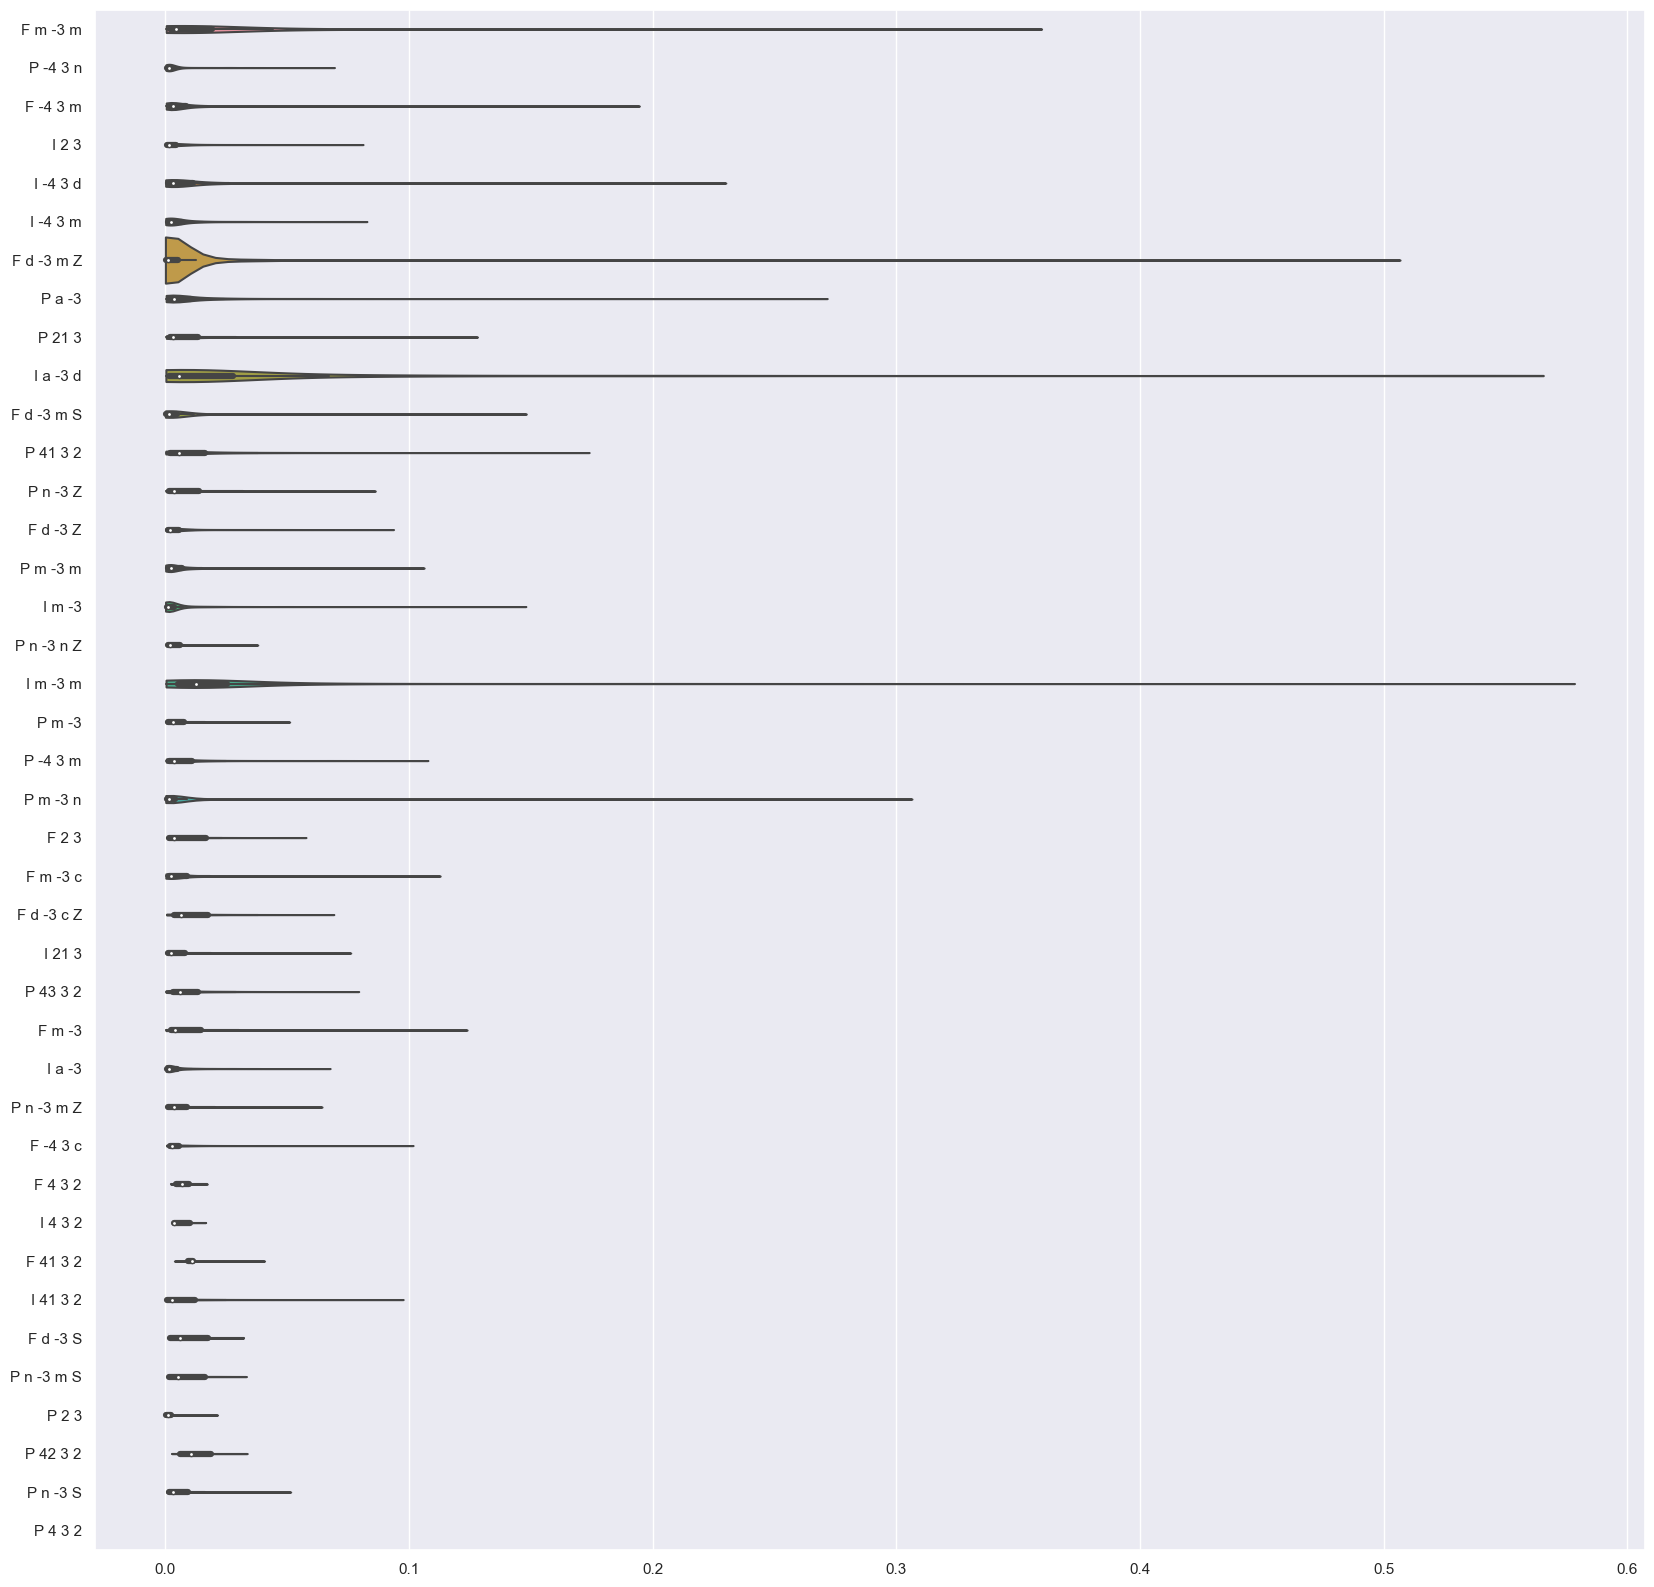

In [124]:
df_la = pd.read_csv("losses_averaged.csv", index_col=0)
# print(df_la.groupby("group").count())
# print()

violin_data = {group:
    np.pad(
        df_la.loc[df_la["group"] == group]["loss"].tolist(),
        pad_width=
        (0,3209-len(df_la.loc[df_la["group"] == group]["loss"].tolist())), mode="constant", constant_values=np.nan
    )
    for group in df_la["group"].unique()
}

# for k, v in violin_data.items():
#     print(k, len(v))

df = pd.DataFrame(violin_data)

fig = plt.figure(figsize=(20, 20))
sns.violinplot(data=df, orient="h", cut=0, scale="count", width=1.2)

# for group in df_la["group"].unique():
#     q1, med, q3 = np.percentile(df_la.loc[df_la["group"] == group]["loss"].tolist(), [25, 50, 75])
#     print(group, q1, med, q3)

In [36]:
losses = pd.read_csv("losses.csv", index_col=0)
# losses.groupby("group").mean().to_csv("group_losses.csv")
losses.mean(axis=1)
# losses.pivot(index="groups", columns="loss0")

C:\Users\joe\AppData\Local\Temp\ipykernel_59904\1942728505.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  losses.mean(axis=1)


code
1000      0.000412
100018    0.000999
10009     0.003261
100098    0.004565
100099    0.001706
            ...   
9988      0.011395
99963     0.006641
99964     0.003158
99965     0.002648
99996     0.002147
Length: 12454, dtype: float64

In [12]:
dfs = {}
means = []
for seed in os.listdir(results_dir):
    dfs[seed] = pd.read_csv(f"{seed}.csv", index_col=0)
    means.append(
        {"seed": seed,
         "test_loss": dfs[seed].groupby("phase").mean()["loss"]["test"],
         "train_loss": dfs[seed].groupby("phase").mean()["loss"]["train"]}
    )

# means

means = pd.DataFrame(means)

means

,seed,test_loss,train_loss
0,seed0_CD,0.024043,0.011017
1,seed1_CD,0.022738,0.008945
2,seed2_CD,0.021506,0.011492
3,seed3_CD,0.022668,0.010862
4,seed4_CD,0.023495,0.011308
5,seedF_-4_3_m_CD,0.088669,0.011842
6,seedF_m_-3_m_CD,0.087663,0.011707
7,seedI_-4_3_d_CD,0.085601,0.011590
8,seedI_-4_3_m_CD,0.083308,0.010869
9,seedP_-4_3_n_CD,0.089540,0.011738
